In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Convolutional Neural Networks
This notebook trains a CNN to classify Cats and Dogs images
1. [Data Preparation](#Data-Preparation)
2. [Build CNN](#Build-CNN)  
    i. [Train](#Train)  
    ii. [Predict on test](#Predict-on-test)  
3. [Finetune Pretrained model - VGG16 model](#Finetune-Pretrained-model---VGG16-model)  
    i. [Training fine-tuned VGG16](#Training-fine-tuned-VGG16)  
    ii. [Predict on test set](#Predict-on-test-set)

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Data Preparation

In [32]:
if "dogs-vs-cats" not in os.getcwd():
    os.chdir('../data/dogs-vs-cats')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/dogs-vs-cats'

In [15]:
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
    for c in random.sample(glob.glob('cat*'), 500):
        shutil.move(c, 'train/cat')
    for c in random.sample(glob.glob('dog*'), 500):
        shutil.move(c, 'train/dog')
    for c in random.sample(glob.glob('cat*'), 100):
        shutil.move(c, 'valid/cat')
    for c in random.sample(glob.glob('dog*'), 100):
        shutil.move(c, 'valid/dog')
    for c in random.sample(glob.glob('cat*'), 50):
        shutil.move(c, 'test/cat')
    for c in random.sample(glob.glob('dog*'), 50):
        shutil.move(c, 'test/dog')

In [20]:
if os.getcwd().split('\\')[-1] != 'Keras':
    os.chdir('../../Keras')

In [36]:
train_path = '../data/dogs-vs-cats/train'
valid_path = '../data/dogs-vs-cats/valid'
test_path = '../data/dogs-vs-cats/test'

In [37]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            classes=['cat','dog'],
                                                                                                                            batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            classes=['cat','dog'],
                                                                                                                            batch_size=10)
# Shuffle = False so assessing results can be consistent
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path,
                                                                                                                            target_size=(224,224),
                                                                                                                            classes=['cat','dog'],
                                                                                                                            batch_size=10,
                                                                                                                            shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [40]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [41]:
imgs, labels = next(train_batches) # Retrieve a batch of 10 

In [45]:
def plotImage(images_arr):
    """
    This function will plot images in the form of a grid with 1 row and 10 columns
    """
    fix, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

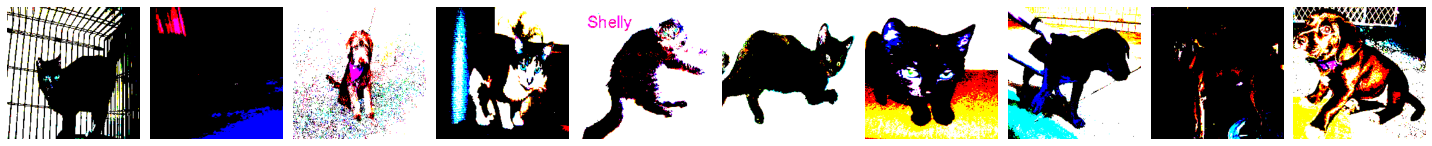

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [47]:
plotImage(imgs)
print(labels)

# Build CNN

In [51]:
model = Sequential(
    [
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        MaxPool2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=2, activation='softmax'),
    ]
)

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [56]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

x = train_batches is a generator  
When data is provided as a generator we don't have to provide labels as the generator stores the data

## Train

In [57]:
history = model.fit(x=train_batches,
                    validation_data=valid_batches,
                    epochs=10,
                    verbose=2)

Epoch 1/10
100/100 - 27s - loss: 0.5220 - accuracy: 0.9270 - val_loss: 3.8183 - val_accuracy: 0.6700
Epoch 2/10
100/100 - 26s - loss: 0.2412 - accuracy: 0.9640 - val_loss: 3.1699 - val_accuracy: 0.6550
Epoch 3/10
100/100 - 25s - loss: 0.1075 - accuracy: 0.9740 - val_loss: 2.8473 - val_accuracy: 0.6650
Epoch 4/10
100/100 - 26s - loss: 0.0593 - accuracy: 0.9830 - val_loss: 2.8375 - val_accuracy: 0.6600
Epoch 5/10
100/100 - 27s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.7479 - val_accuracy: 0.6500
Epoch 6/10
100/100 - 27s - loss: 1.6809e-04 - accuracy: 1.0000 - val_loss: 2.7520 - val_accuracy: 0.6550
Epoch 7/10
100/100 - 27s - loss: 1.3376e-04 - accuracy: 1.0000 - val_loss: 2.7517 - val_accuracy: 0.6550
Epoch 8/10
100/100 - 27s - loss: 1.1304e-04 - accuracy: 1.0000 - val_loss: 2.7539 - val_accuracy: 0.6550
Epoch 9/10
100/100 - 27s - loss: 9.8464e-05 - accuracy: 1.0000 - val_loss: 2.7539 - val_accuracy: 0.6550
Epoch 10/10
100/100 - 27s - loss: 8.7525e-05 - accuracy: 1.0000 - val_loss:

## Predict on test
Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

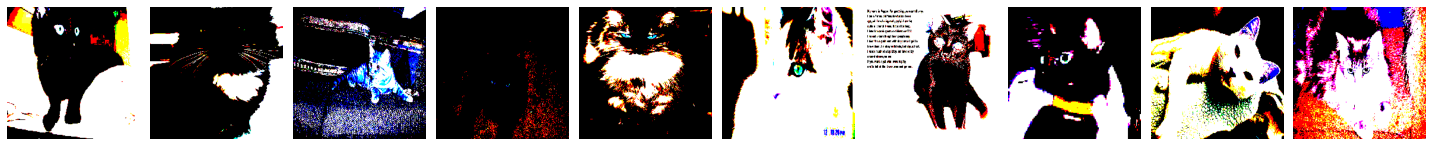

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [59]:
test_imgs, test_labels = next(test_batches)
plotImage(test_imgs)
print(test_labels)

In [60]:
#Unshuffled
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [62]:
pred = model.predict(x=test_batches, verbose=2)

10/10 - 1s


In [66]:
np.round(pred)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [72]:
np.argmax(pred, axis=-1)

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int64)

In [73]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=1))

In [74]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalisation can be applied by setting 'normalize=True'
    """
    import itertools
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalisation')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix without normalisation
[[36 14]
 [14 36]]


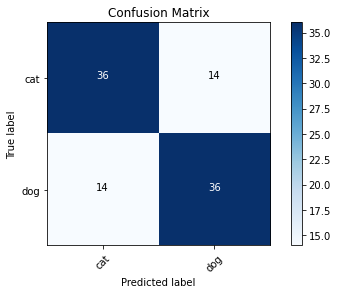

In [77]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, classes=cm_plot_labels, title='Confusion Matrix')

# Finetune Pretrained model - VGG16 model

Different from transfer learning  

1. Freeze hiddenlayer
2. only train the last layer

In [78]:
# Requires Internet connection
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 16s 0us/step


In [80]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [81]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [82]:
# Convert VGG functional model into sequential model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

Freezing trained layer

In [84]:
for layer in model.layers:
    layer.trainable = False

In [86]:
model.add(Dense(units=2, activation="softmax"))

In [87]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Training fine-tuned VGG16

In [88]:
imgs, labels = next(train_batches)

In [89]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics =['accuracy'])

In [90]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 147s - loss: 0.2396 - accuracy: 0.9060 - val_loss: 0.1513 - val_accuracy: 0.9450
Epoch 2/5
100/100 - 108s - loss: 0.0669 - accuracy: 0.9780 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 3/5
100/100 - 134s - loss: 0.0410 - accuracy: 0.9860 - val_loss: 0.1085 - val_accuracy: 0.9600
Epoch 4/5
100/100 - 140s - loss: 0.0264 - accuracy: 0.9930 - val_loss: 0.1017 - val_accuracy: 0.9700
Epoch 5/5
100/100 - 147s - loss: 0.0193 - accuracy: 0.9980 - val_loss: 0.0997 - val_accuracy: 0.9600


## Predict on test set

In [91]:
pred = model.predict(x=test_batches, verbose=2)

10/10 - 12s


In [92]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [93]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred = np.argmax(pred, axis=1))

In [95]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix without normalisation
[[48  2]
 [ 2 48]]


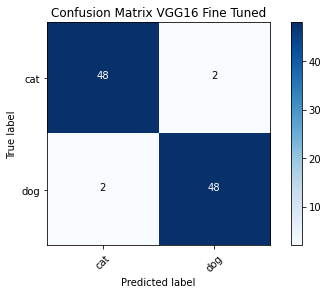

In [96]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix VGG16 Fine Tuned')